<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

<img style="float:left" src="https://i.pinimg.com/favicons/785714a231b17c8744878eca10e1720d6e7facfc28877c965dfb17c4.ico?81e86945d3dc421cb83147bcb4f1c59e" />

# Sections
* [Description](#0)
* [1. Setup](#1)
* [2. Data Structure](#2)
  * [2.1 Data Information](#2.1)
* [3. Data Preparation](#3)
  * [3.1 Data Cleaning](#3.1)
  * [3.2 Exploratory Data Analysis](#3.2)
  * [3.3 Feature Engineering](#3.3)
       * [3.3.1 Feature Transformation & Assembling](#3.3.1) 
* [4. Model Training](#4)
* [5. Model Selection & Evaluation](#5)
    * [5.1 Linear Regression](#5.1)
    * [5.1.2 Naive Bayes](#5.1.2)
    * [5.1.3  SVM](#5.1.3)
    * [5.2 Our 2022 Best Picture Prediction](#5.2)
* [6. Model Persistence](#6)
* [7. Model Loading](#7)

<a id='0'></a>
## Description 


The goal is to create a machine learning model using ML Lib in Apache Spark to predict the 2022 Best Picture Winner for the Academy Awards
(better known as the Oscars)

Business Question: What are the relevant key components among the Best Picture nominees, and what does it take to become a winner?


<a id='1'></a>
## 1. Setup

Import all necessary libraries

In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)

from datetime import datetime

In [3]:
dt = datetime.now()

In [4]:
ts = datetime.timestamp(dt)

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import isnull, when, count, col, split, isnan
from pyspark.sql.types import ArrayType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel

In [6]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

Time to create the SparkSession which we'll use to send our Spark code:

In [7]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Academy Award Winners - MLlib")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .enableHiveSupport()
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Data Structure

<a id=‘2.2’></a>
### 2.1 Data Information
Data Dictionary for Academy Award Best Picture Nominees and Winners:
Each record includes the general information for the movies that were nominated to each years Academy Awards (Oscars). The original dataset  from Martin Mraz on Kaggle includes ratings from IMDB and RottenTomatoes. Added ratings for some movies which were not included. You can find the updated dataset in the documentation.

Original dataset: https://www.kaggle.com/datasets/martinmraz07/oscar-movies

<table style=“float:left”>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Type</b></th></tr>
<tr>
<td>Film</td>
<td>Movie name.</td>
<td>Text</td>
</tr>
<tr>
<td>OscarYear</td>
<td>Year when the Academy Awards took place.</td>
<td>Integer</td>
</tr>
<tr>
<td>FilmStudio/Producers</td>
<td>Mixed information about the Film Studio and Producers</td>
<td>Text</td>
</tr>
<tr>
<td>Award</td>
<td>Winner or Nominee</td>
<td>Text</td>
</tr>
<tr>
<tr>
<td>AwardBinary</td>
<td>Nominees are assigned a 0 and winners are assigned a 1</td>
<td>Text</td>
</tr>
<tr>    
<td>YearofRelease</td>
<td>Year when the movie was released</td>
<td>Integer</td>
</tr>
<tr>
<td>MovieTime</td>
<td>Movie run time</td>
<td>Integer</td>
</tr>
<tr>
<td>MovieGenre1</td>
<td>Genres classification</td>
<td>Text</td>
</tr>
<tr>
<td>MovieGenre2</td>
<td>Genres classification</td>
<td>Text</td>
</tr>
<tr>
<td>MovieGenre3</td>
<td>Genres classification</td>
<td>Text</td>
</tr>
<tr>
<td>IMDB Rating</td>
<td>Rating awarded by the users of IMDB</td>
<td>Float</td>
</tr>
<tr>
<td>IMDB Votes</td>
<td>Total amount of votes received from IMDB users</td>
<td>Integer</td>
</tr>
<tr>
<td>MovieInfo</td>
<td>Movie description</td>
<td>Text</td>
</tr>
<tr>
<td>CriticConsensus</td>
<td>Critics summarized opinion about the movie.</td>
<td>Text</td>
</tr>
<tr>
<td>ContentRating</td>
<td>Content rating rates the suitability of TV broadcasts, movies, comic books, or video games to its audience. </td>
<td>Text</td>
</tr>
<tr>
<td>Directors</td>
<td>Movie director names</td>
<td>Text</td>
</tr>
<tr>
<td>Authors</td>
<td>Movie screenwriters names</td>
<td>Text</td>
</tr>
<tr>
<td>Actors</td>
<td>Main actor name</td>
<td>Text</td>
</tr>
<tr>
<td>Actors2</td>
<td>Supporting actor name </td>
<td>Text</td>
</tr>
<tr>
<td>Actors3</td>
<td>Second supporting actor name </td>
<td>Text</td>
</tr>
<tr>
<td>OriginalReleaseDate</td>
<td>Movie date of release</td>
<td>Date & Time</td>
</tr>
<tr>
<td>StreamingDate</td>
<td>Movie streaming date</td>
<td>Date & Time</td>
</tr>
<tr>
<td>ProductionCompany</td>
<td>Name of the company that produced the movie</td>
<td>Text</td>
<tr>
<td>TomatometerStatus</td>
<td>A short description of RottenTomatoes' recommendation status for the movie</td>
<td>Text</td>
<tr>
<td>TomatometerRating</td>
<td>RottenTomatoes' score for critics ratings</td>
<td>Integer</td>
<tr>
<td>TomatometerCount</td>
<td>Total count of reviews submitted on RottenTomatoes</td>
<td>Integer</td>
<tr>
<td>AudienceStatus</td>
<td>A short description of the general publics opinion of the movie</td>
<td>Text</td>
<tr>
<td>AudienceRating</td>
<td>The audience combined review scores</td>
<td>Integer</td>
<tr>
<td>AudienceCount</td>
<td>Total count of the audience submitted reviews</td>
<td>Integer</td>
<tr>
<td>TomatometertopCriticsCounts</td>
<td>Number of certified top critics on Tomatometer that submitted a review for the movie</td>
<td>Integer</td>
<tr>
<td>TomatometertopFreshCriticsCounts</td>
<td>Number of ratings submitted by top critics with a fresh rating</td>
<td>Integer</td>
<tr>
<td>TomatometerRottenCriticsCount</td>
<td>Number of ratings submitted by top critics with a rotten rating</td>
<td>Integer</td>
<tr>
<td>FilmID</td>
<td>Unique movie identifier on RottenTomatoes</td>
<td>Text</td>
</tbody>
</table>



<a id='3'></a>
## 3. Data Preparation

<a id='3.1'></a>
### 3.1 Data Cleaning

Reading raw data on Pandas

In [8]:
oscars_raw = pd.read_csv("oscars_df_v1.csv")

Set up schema for dataset

In [9]:
oscarsSchema = StructType([StructField('Film', StringType(), True),
                         StructField('OscarYear', StringType(), True),
                         StructField('FilmStudioProducer', StringType(), True),
                         StructField('Award', StringType(), True),
                         StructField('AwardBinary', FloatType(), True),   
                         StructField('YearofRelease', StringType(), True),
                         StructField('MovieTime', IntegerType(), True),
                         StructField('MovieGenre1', StringType(), True),
                         StructField('MovieGenre2', StringType(), True),
                         StructField('MovieGenre3', StringType(), True),
                         StructField('IMDBRating', FloatType(), True),
                         StructField('IMDBVotes', IntegerType(), True),
                         StructField('MovieInfo', StringType(), True),
                         StructField('CriticConsensus', StringType(), True),
                         StructField('ContentRating', StringType(), True),
                         StructField('Directors', StringType(), True),
                         StructField('Authors', StringType(), True),
                         StructField('Actors', StringType(), True),
                         StructField('Actors2', StringType(), True),
                         StructField('Actors3', StringType(), True),
                         StructField('OriginalReleaseDate', StringType(), True),
                         StructField('StreamingReleaseDate', StringType(), True),
                         StructField('ProductionCompany', StringType(), True),
                         StructField('TomatometerStatus', StringType(), True),
                         StructField('TomatometerRating', IntegerType(), True),
                         StructField('TomatometerCount', IntegerType(), True),
                         StructField('AudienceStatus', StringType(), True),
                         StructField('AudienceRating', IntegerType(), True),
                         StructField('AudienceCount', IntegerType(), True),
                         StructField('TomatometerTopCriticsCount', IntegerType(), True),
                         StructField('TomatometerFreshCriticsCount', IntegerType(), True),
                         StructField('TomatometerRottenCriticsCount', IntegerType(), True),
                         StructField('FilmID', StringType(), True),
    
])

Creating DataFrame on Spark from the schema that was set up

In [10]:
oscarsDF = spark.createDataFrame(oscars_raw, schema = oscarsSchema)
len(oscarsDF.columns)

33

<a id='3.2'></a>
### 3.2 Exploratory Data Analysis

**Summary of data**:

In [11]:
oscars_count = oscarsDF.count()
print (f"Total number of Best Picture nominees from 1927 to 2022 : {oscars_count}")

Total number of Best Picture nominees from 1927 to 2022 : 581


**In which years has the Academy Awards ceremony been held?**

In [12]:
oscarsDF.select('OscarYear').distinct().orderBy('OscarYear').show()

+---------+
|OscarYear|
+---------+
|     1927|
|     1928|
|     1929|
|     1930|
|     1931|
|     1932|
|     1934|
|     1935|
|     1936|
|     1937|
|     1938|
|     1939|
|     1940|
|     1941|
|     1942|
|     1943|
|     1944|
|     1945|
|     1946|
|     1947|
+---------+
only showing top 20 rows



**Which Best Picture nominees have the highest IMDB rating?**

In [13]:
oscarsDF.select('Film','IMDBRating').orderBy('IMDBRating',ascending = False).show(5)

+--------------------+----------+
|                Film|IMDBRating|
+--------------------+----------+
|The Shawshank Red...|       9.3|
|       The Godfather|       9.2|
|The Godfather Par...|       9.0|
|        12 Angry Men|       9.0|
|The Lord of the R...|       8.9|
+--------------------+----------+
only showing top 5 rows



<a id='3.3'></a>
### 3.3 Feature Engineering

It's time to convert data into a suitable format for machine learning algorithms.<br/> 

First, create a correlation matrix to evaluate whether we should drop any columns

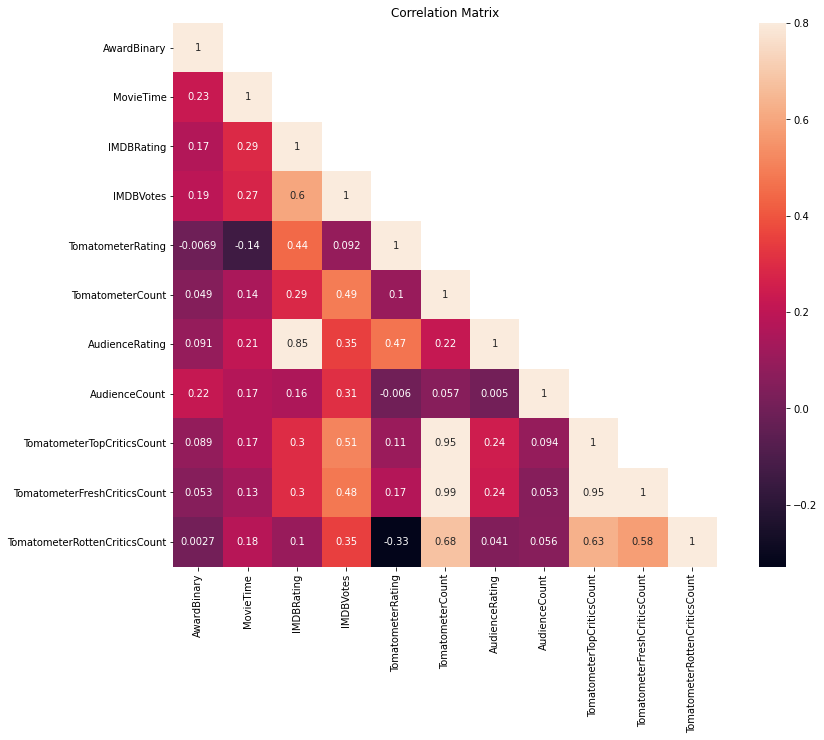

In [14]:
oscar_corr = oscarsDF.toPandas()

fig, ax = plt.subplots(figsize = (15,10))  
corrMatrix = oscar_corr.corr()
mask = np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrMatrix, mask = mask, vmax = 0.8, square = True, annot = True, ax = ax)

plt.title("Correlation Matrix")
plt.show()

There are columns with high correlations, such as IMDBRating and IMDBVotes, but will not be dropped in this case because they are relevant to the analysis. Instead, the following columns were dropped because they will not add any relevant insights:

In [15]:
oscarsDF = oscarsDF.drop(
    "MovieInfo","CriticConsensus","Authors",
    "OriginalReleaseDate","StreamingReleaseDate","TomatometerStatus",
    "AudienceStatus","FilmID","Award")

**Evaluating Null Values**

In [16]:
oscarsDF.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c) for c in oscarsDF.columns]).toPandas()

,Film,OscarYear,FilmStudioProducer,AwardBinary,YearofRelease,MovieTime,MovieGenre1,MovieGenre2,MovieGenre3,IMDBRating,IMDBVotes,ContentRating,Directors,Actors,Actors2,Actors3,ProductionCompany,TomatometerRating,TomatometerCount,AudienceRating,AudienceCount,TomatometerTopCriticsCount,TomatometerFreshCriticsCount,TomatometerRottenCriticsCount
0,0,0,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No null values in the remaining columns, so no need to do any imputing.

<a id='3.3.1'></a>
#### 3.3.1 Feature Transformation & Assembling

We need to translate the values in string columns into  numerical values as well as scale the numerical columns we have.

First, isolate the target variable and then create lists of the different kinds of columns

In [17]:
label_column = "AwardBinary"

categoricalCols = [field for (field, dataType) in oscarsDF.dtypes if ((dataType == "string") & (field != label_column))]
integerCols = [field for (field, dataType) in oscarsDF.dtypes if ((dataType == "int") & (field != label_column))]
floatCols = [field for (field, dataType) in oscarsDF.dtypes if ((dataType == "float") & (field != label_column))]

numericalCols = integerCols + floatCols

Use StringIndexer and OneHotEnconder to encode the categorical columns

In [18]:
indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in categoricalCols]

encoders = [StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
for indexer in indexers]

Then, create a Vector Assembler for the encoded categorical columns

In [19]:
assemblerCat = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "cat")

The next step is to create a pipeline that includes the indexers, encoders and categorical columns. Then,fit and transform the pipeline ot the oscarsDF

In [20]:
pipelineCat = Pipeline(stages = indexers + encoders + [assemblerCat])
oscarsDF = pipelineCat.fit(oscarsDF).transform(oscarsDF)

Create a separate Vector Assembler for the numerical columns 

In [21]:
assemblerNum = VectorAssembler(inputCols = numericalCols, outputCol = "num")

pipelineNum = Pipeline(stages = [assemblerNum])
oscarsDF = pipelineNum.fit(oscarsDF).transform(oscarsDF)

Finally, combine both the categorical and numerical assemblers

In [22]:
assembler = VectorAssembler(inputCols = ["cat", "num"], outputCol = "features")

<a id='4'></a>
## 4. Model Training

In [23]:
seed = 48

Use a Stratified Train-Test Split because the dataset is unbalanced (more nominees than winners)

In [24]:
(trainingData, testData) = oscarsDF.filter(oscarsDF.OscarYear != 2021).randomSplit([0.75,0.25],seed=seed)

In [25]:
(trainingData1, testData1) = oscarsDF.filter((oscarsDF.AwardBinary == 0) & (oscarsDF.OscarYear != 2021)).randomSplit([0.75,0.25],seed=seed)
(trainingData2, testData2) = oscarsDF.where((oscarsDF.AwardBinary == 1) & (oscarsDF.OscarYear != 2021)).randomSplit([0.75,0.25],seed=seed)

trainingData = trainingData1.unionByName(trainingData2)
testData = testData1.unionByName(testData2)

In [26]:
lr = LogisticRegression(labelCol="AwardBinary", featuresCol="features")
nb = NaiveBayes(labelCol="AwardBinary", featuresCol="features")
svm = LinearSVC(labelCol="AwardBinary", featuresCol="features")

<a id='5'></a>
## 5. Model Selection & Evaluation

Let's try different classifiers for our data, and use accuracy as a metric to evaluate. Additionally, let's create a confusion matrix for each of them

<a id='5.1.1'></a>
#### 5.1.1 Logistic Regression

In [27]:
lr_pipeline = Pipeline(stages = [assembler,lr])

lr_model = lr_pipeline.fit(trainingData)

lr_evaluator = MulticlassClassificationEvaluator(labelCol="AwardBinary",  metricName="accuracy")

In [28]:
prediction_lr = lr_model.transform(testData)
accuracy_lr = lr_evaluator.evaluate(prediction_lr)
accuracy_lr

0.8402777777777778

In [29]:
lr_model.transform(testData).groupby("AwardBinary").pivot("prediction").count().toPandas()

,AwardBinary,0.0,1.0
0,1.0,19,3
1,0.0,118,4


<a id='5.1.2'></a>
#### 5.1.2 Naive Bayes

In [30]:
nb_pipeline = Pipeline(stages = [assembler,nb])

nb_model = nb_pipeline.fit(trainingData)

evaluator_nb = MulticlassClassificationEvaluator(labelCol="AwardBinary",  metricName="accuracy")

In [31]:
prediction_nb = nb_model.transform(testData)
accuracy_nb = evaluator_nb.evaluate(prediction_nb)
accuracy_nb

0.7777777777777778

In [32]:
nb_model.transform(testData).groupby("AwardBinary").pivot("prediction").count().toPandas()

,AwardBinary,0.0,1.0
0,1.0,20,2
1,0.0,110,12


<a id='5.1.3'></a>
#### 5.1.3 Support Vector Machine

In [33]:
svm_pipeline = Pipeline(stages = [assembler,svm])

svm_model = svm_pipeline.fit(trainingData)

evaluator_svm = MulticlassClassificationEvaluator(labelCol="AwardBinary",  metricName="accuracy")

In [34]:
prediction_svm = svm_model.transform(testData)
accuracy_svm = evaluator_svm.evaluate(prediction_svm)
accuracy_svm

0.8611111111111112

In [35]:
svm_model.transform(testData).groupby("AwardBinary").pivot("prediction").count().toPandas()

,AwardBinary,0.0,1.0
0,1.0,20,2.0
1,0.0,122,NaN


Even though the SVM model had the best accuracy, logistic regression will be the final model because it accurately predicted some winners (as seen in the confusion matrix) and has the second-best accuracy score. 

<a id='5.2'></a>
### 5.2 Our 2022 Best Picture Prediction

In [36]:
#Adding date & timestamp to show this model was run before the Academy Awards ceremony, which was hosted on 03-27-22 at 5pm Pacific Time (LA) 
print(dt)

2022-03-26 21:26:07.462712


In [37]:
nominees_2022= oscarsDF.filter(oscarsDF.OscarYear == 2021)

final_model = lr_pipeline.fit(trainingData)
final_prediction = final_model.transform(nominees_2022)
final_prediction['Film','probability','prediction'].toPandas()

,Film,probability,prediction
0,Nightmare Alley,"[0.9200524733804194, 0.07994752661958053]",0.0
1,Dune,"[0.9448078551652073, 0.055192144834792706]",0.0
2,Belfast,"[0.8267534811140591, 0.17324651888594086]",0.0
3,The Power of the Dog,"[0.77065037877373, 0.22934962122626998]",0.0
4,King Richard,"[0.5678520358481198, 0.4321479641518801]",0.0
5,Don't Look Up,"[0.9548725828214091, 0.04512741717859091]",0.0
6,Drive My Car,"[0.469410447591629, 0.530589552408371]",1.0
7,Licorice Pizza,"[0.7449011866367794, 0.25509881336322054]",0.0
8,West Side Story,"[0.8508861848833311, 0.1491138151166689]",0.0
9,CODA,"[0.3511703888679766, 0.6488296111320234]",1.0


The 2022 Best Picture prediction is **CODA** since it has the highest probability (0.6488)

<a id='6'></a>
## 6. Model Persistence

Spark provides functionality to save the model/pipeline so that we can use it later for inference (batch or streaming)

In [38]:
modelPath = "hdfs://localhost:9000/model-registry/Academy-Awards-Classifier"
final_model.write().overwrite().save(modelPath)

22/03/26 21:27:18 ERROR Instrumentation: java.net.ConnectException: Call From osbdet/127.0.0.1 to localhost:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
	at org.apache.hadoop.net.NetUtils.wrapWithMessage(NetUtils.java:831)
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:755)
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1515)
	at org.apache.hadoop.ipc.Client.call(Client.java:1457)
	at org.apache.hadoop.ipc.Client.call(Client.java:1367)
	at org.ap

Py4JJavaError: An error occurred while calling o2556.save.
: java.net.ConnectException: Call From osbdet/127.0.0.1 to localhost:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
	at org.apache.hadoop.net.NetUtils.wrapWithMessage(NetUtils.java:831)
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:755)
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1515)
	at org.apache.hadoop.ipc.Client.call(Client.java:1457)
	at org.apache.hadoop.ipc.Client.call(Client.java:1367)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:228)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:116)
	at com.sun.proxy.$Proxy32.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:903)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:422)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeMethod(RetryInvocationHandler.java:165)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invoke(RetryInvocationHandler.java:157)
	at org.apache.hadoop.io.retry.RetryInvocationHandler$Call.invokeOnce(RetryInvocationHandler.java:95)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:359)
	at com.sun.proxy.$Proxy33.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:1665)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1582)
	at org.apache.hadoop.hdfs.DistributedFileSystem$29.doCall(DistributedFileSystem.java:1579)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1594)
	at org.apache.hadoop.fs.FileSystem.exists(FileSystem.java:1683)
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:675)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:176)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:171)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:777)
	at org.apache.hadoop.net.SocketIOWithTimeout.connect(SocketIOWithTimeout.java:206)
	at org.apache.hadoop.net.NetUtils.connect(NetUtils.java:531)
	at org.apache.hadoop.ipc.Client$Connection.setupConnection(Client.java:690)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:794)
	at org.apache.hadoop.ipc.Client$Connection.access$3700(Client.java:411)
	at org.apache.hadoop.ipc.Client.getConnection(Client.java:1572)
	at org.apache.hadoop.ipc.Client.call(Client.java:1403)
	... 45 more


<a id='7'></a>
## 7. Model Loading

In [ ]:
savedModel = PipelineModel.load(modelPath)

In [ ]:
predictions = savedModel.transform(testData)
predictions.select("features", "AwardBinary", "prediction").limit(200).toPandas()